# Handling Multicollinearity with PCR and PLSR
_Group 5 Presentation_

Multivariate Regression Methods

## What is Multicollinearity?

- Situation where predictors (X variables) are highly correlated:
  
  $$X_2 \approx \alpha + \beta_1 \cdot X_1$$
  

  $$X_3 \approx \alpha + \beta_1\cdot X_1 + \beta_2 \cdot X_2$$


- Multiple Linear Regression (MLR) struggles:
  - Unstable regression coefficients
  - Hard to interpret results


## Detecting Multicollinearity: Simple example

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

np.random.seed(42)

X1 = np.random.normal(0, 1, 100)
X2 = X1 * 0.8 + np.random.normal(0, 0.2, 100)
X3 = np.random.normal(0, 1, 100)

X = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3})
y = 2*X1 + 3*X2 + np.random.normal(0, 0.5, 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Visualization

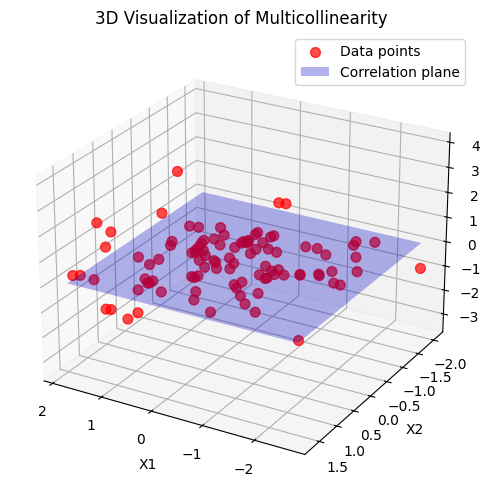

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1, X2, X3, c='red', s=50, alpha=0.7, label='Data points')

X1_grid, X2_grid = np.meshgrid(np.linspace(X1.min(), X1.max(), 10),
                               np.linspace(X2.min(), X2.max(), 10))
X3_plane = np.mean(X3) + 0*X1_grid  # Plane along mean of X3
ax.plot_surface(X1_grid, X2_grid, X3_plane, color='blue', alpha=0.3, label='Correlation plane')

# Labels and title
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('3D Visualization of Multicollinearity')
ax.view_init(elev=25, azim=120)
ax.legend()

plt.show()

## Detecting Multicollinearity: Correlation Matrix

A simple first step is to inspect the **correlation matrix** of predictors:

- High absolute correlations (e.g., |ρ| > 0.8) suggest **collinearity**.
- Limitation: only detects **pairwise** relationships, not general multicollinearity.



### **Visualization:** Heatmap of correlation coefficients.

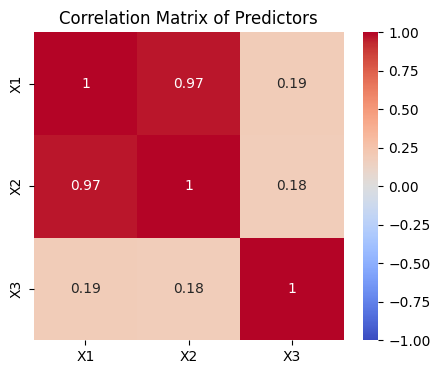

In [ ]:
import seaborn as sns
# 1. Correlation Matrix
corr_matrix = X.corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Predictors')
plt.show()

## Detecting Multicollinearity: Variance Inflation Factor (VIF)

**Definition:**
$$
\text{VIF}_j = \frac{1}{1 - R_j^2}
$$
where $R_j^2$ is the coefficient of determination when regressing predictor $x_j$ on all other predictors.

- Interpretation:
  - VIF ≈ 1 → no collinearity
  - VIF > 5 → moderate multicollinearity
  - VIF > 10 → severe multicollinearity

If $x_j$ is highly predictable from others, $R_j^2$ is large → denominator small → VIF large.


##  

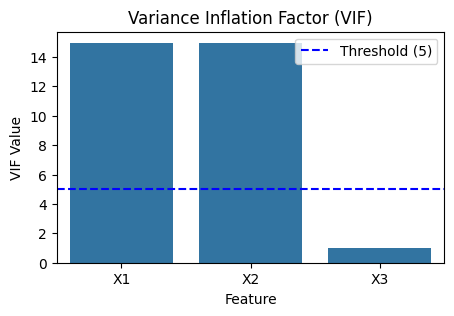

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2. Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# print("Variance Inflation Factor (VIF):")
# print(vif_data)

plt.figure(figsize=(5,3))
sns.barplot(x='Feature', y='VIF', data=vif_data)
plt.axhline(5, color='blue', linestyle='--', label='Threshold (5)')
plt.title('Variance Inflation Factor (VIF)')
plt.ylabel('VIF Value')
plt.legend()
plt.show()

## Detecting Multicollinearity: Condition Number

Based on the eigenvalues of $X^\top X$:

$$
\kappa = \sqrt{\frac{\lambda_{\max}}{\lambda_{\min}}}
$$

- Large condition number ($\kappa > 30$) indicates severe multicollinearity.
<!-- - **Condition indices**: For each eigenvalue $\lambda_i$:
$$
CI_i = \sqrt{\frac{\lambda_{\max}}{\lambda_i}}
$$ -->

Small eigenvalues → nearly dependent columns → unstable inversion in MLR.


##

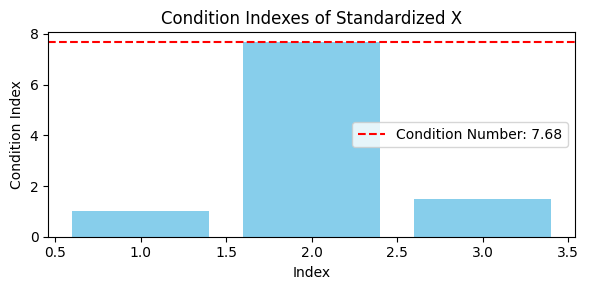

In [ ]:
# 3. Condition Number
from sklearn.preprocessing import StandardScaler

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute eigenvalues of X^T X
eigenvalues = np.linalg.eigvals(X_scaled.T @ X_scaled)

# Compute condition indexes
condition_indexes = [np.sqrt(eigenvalues.max() / l) for l in eigenvalues]
condition_number = max(condition_indexes)

# Plot condition indexes
plt.figure(figsize=(6, 3))
plt.bar(range(1, len(condition_indexes) + 1), condition_indexes, color='skyblue')
plt.axhline(y=condition_number, color='red', linestyle='--', label=f'Condition Number: {condition_number:.2f}')
plt.xlabel('Index')
plt.ylabel('Condition Index')
plt.title('Condition Indexes of Standardized X')
plt.legend()
plt.tight_layout()
plt.show()

## Alternative Solutions (before PCR/PLSR)

- Drop variables
- Combine variables manually
- LASSO (L1)
- Ridge Regression (L2)

➡ But: these methods may lose information

## Principal Component Regression (PCR)
PCR = PCA + MLR

### How it solves multicollinearity
- PCA transforms correlated predictors into new orthogonal axes (principal components).
- These components are independent of each other.


| **Pros**                                               | **Cons**                                  |
|--------------------------------------------------------|-------------------------------------------|
| Handles multicollinearity   | Components chosen by X variance, not by Y |
| Reduces dimensionality      |                                           |


## Partial Least Squares Regression (PLSR)
- Similar to PCR but with focus on the prediction variable Y, **maximize covariance between X and Y**
- Latent variables represent both X structure and relation to Y

#### How it solves multicollinearity
- PLSR constructs latent components that are uncorrelated (like PCA).
- Keeps only information that is useful for prediction.


| **Pros**                              | **Cons**                          |
|---------------------------------------|-----------------------------------|
| Handles multicollinearity             | More complex, less intuitive     |
| Components directly linked to **Y**   |                                   |


## PCR vs. PLSR

| Feature      | PCR                        | PLSR                      |
|--------------|----------------------------|----------------------------|
| Basis        | Variance in X              | Covariance of X and Y      |
| Goal         | Dimension reduction        | Prediction of Y            |
| Collinearity | Removed                    | Removed                    |
| Use case     | Explore predictors         | Predictive modeling        |

## Examples

## Example 1 - PCR vs PLSR
 Created a dataset with two features and applied PCA to find the main directions of variance.
- Defined the target `y` to align with the second principal component (low variance direction).
- Added noise to the projection to simulate realistic correlation.

Reference:

[1] https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html


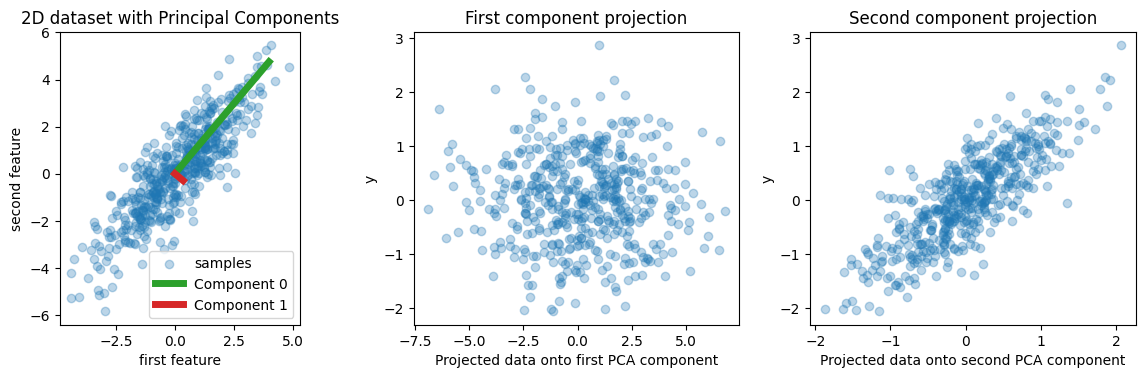

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

rng = np.random.RandomState(0)
n_samples = 500
cov = [[3, 3], [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
pca = PCA(n_components=2).fit(X)

y = X.dot(pca.components_[1]) + rng.normal(size=n_samples) / 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# # First plot: original data and principal components
ax = axes[0]
ax.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale by explained variance
    ax.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5, color=f"C{i + 2}")
ax.set(
    aspect="equal",
    title="2D dataset with Principal Components",
    xlabel="first feature",
    ylabel="second feature"
)
ax.legend()

# Second plot: Projected on 1st component vs y
axes[1].scatter(X.dot(pca.components_[0]), y, alpha=0.3)
axes[1].set(
    xlabel="Projected data onto first PCA component",
    ylabel="y",
    title="First component projection"
)

# Third plot: Projected on 2nd component vs y
axes[2].scatter(X.dot(pca.components_[1]), y, alpha=0.3)
axes[2].set(
    xlabel="Projected data onto second PCA component",
    ylabel="y",
    title="Second component projection"
)

plt.tight_layout(pad=1.5)
plt.show()


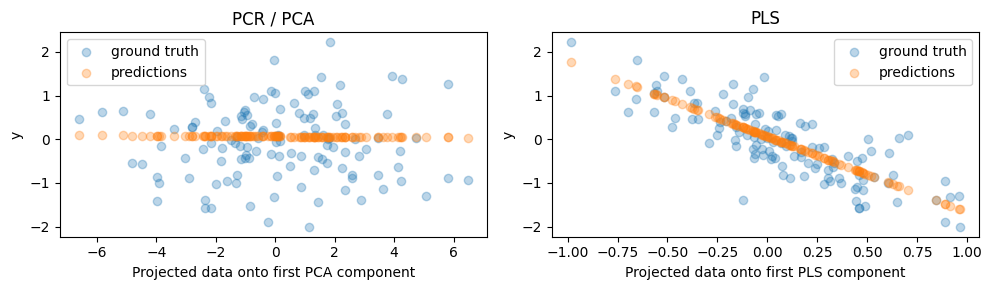

In [ ]:
# @title
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared -0.026
PLS r-squared 0.658


- PCR  uses unsupervised PCA, which may drop the most predictive direction if it has low variance, leading to poor predictive power.

- PLS  leverages target information in its transformation, allowing it to capture the most predictive direction, even with lower variance.

## Example 2 - bodyfat

In [ ]:
!pip install openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.1 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=547848eda99bb5b72088d00ec2c78927e3d3f3ce1ecd2c3b4475ecff7a79155d
  Stored in directory: /root/.cache/pip/wheels/a9/ac/cf/c2919807a5c623926d217c0a18eb5b457e5c19d242c3b5963a
Successfully built liac-arff


In [ ]:
# @title
import openml

dataset = openml.datasets.get_dataset('bodyfat')
data, _, _, _ = dataset.get_data(dataset_format="dataframe")

In [ ]:
data.head()

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,class
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.3
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.1
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,25.3
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.4
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,28.7


In [ ]:
data.corr()

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,class
Density,1.000000,-0.277637,-0.594062,0.097881,-0.472966,-0.682599,-0.798955,-0.609331,-0.553091,-0.495040,-0.264890,-0.487109,-0.351648,-0.325716,-0.987782
Age,-0.277637,1.000000,-0.012746,-0.171645,0.113505,0.176450,0.230409,-0.050332,-0.200096,0.017516,-0.105058,-0.041162,-0.085056,0.213531,0.291458
Weight,-0.594062,-0.012746,1.000000,0.308279,0.830716,0.894191,0.887995,0.940884,0.868694,0.853167,0.613685,0.800416,0.630301,0.729775,0.612414
Height,0.097881,-0.171645,0.308279,1.000000,0.253710,0.134892,0.087813,0.170394,0.148436,0.286053,0.264744,0.207816,0.228649,0.322065,-0.089495
Neck,-0.472966,0.113505,0.830716,0.253710,1.000000,0.784835,0.754077,0.734958,0.695697,0.672405,0.477892,0.731146,0.623660,0.744826,0.490592
Chest,-0.682599,0.176450,0.894191,0.134892,0.784835,1.000000,0.915828,0.829420,0.729859,0.719496,0.482988,0.727907,0.580173,0.660162,0.702620
Abdomen,-0.798955,0.230409,0.887995,0.087813,0.754077,0.915828,1.000000,0.874066,0.766624,0.737179,0.453223,0.684983,0.503316,0.619832,0.813432
Hip,-0.609331,-0.050332,0.940884,0.170394,0.734958,0.829420,0.874066,1.000000,0.896410,0.823473,0.558387,0.739273,0.545014,0.630090,0.625201
Thigh,-0.553091,-0.200096,0.868694,0.148436,0.695697,0.729859,0.766624,0.896410,1.000000,0.799170,0.539797,0.761477,0.566842,0.558685,0.559608
Knee,-0.495040,0.017516,0.853167,0.286053,0.672405,0.719496,0.737179,0.823473,0.799170,1.000000,0.611608,0.678709,0.555898,0.664507,0.508665


Text(0.5, 1.0, 'Correlation Matrix')

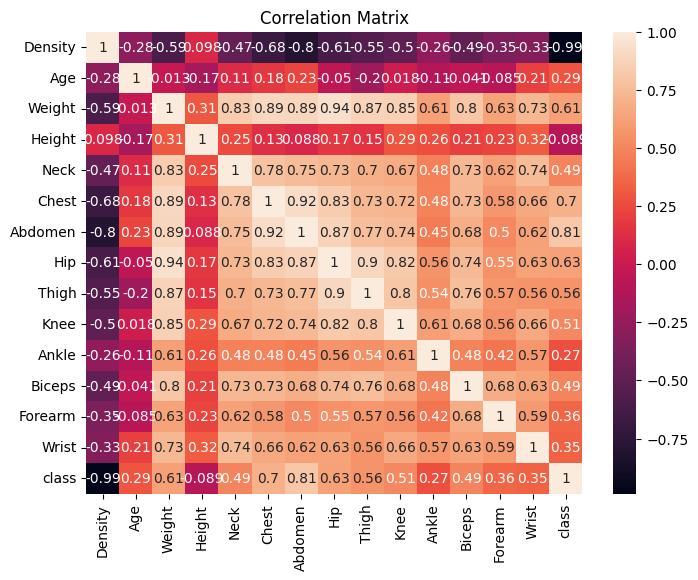

In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# plot correlation matrix
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation Matrix')

In [ ]:
#@title
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = data.drop('class', axis=1)
# VIF dataframe
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns

# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_df)

    Feature          VIF
0   Density  2710.196700
1       Age    31.087967
2    Weight   927.258823
3    Height   582.893107
4      Neck  1081.582064
5     Chest  1327.734644
6   Abdomen   992.381183
7       Hip  2823.599196
8     Thigh  1001.990668
9      Knee  1174.133421
10    Ankle   351.401683
11   Biceps   416.486099
12  Forearm   442.122445
13    Wrist  1339.993165


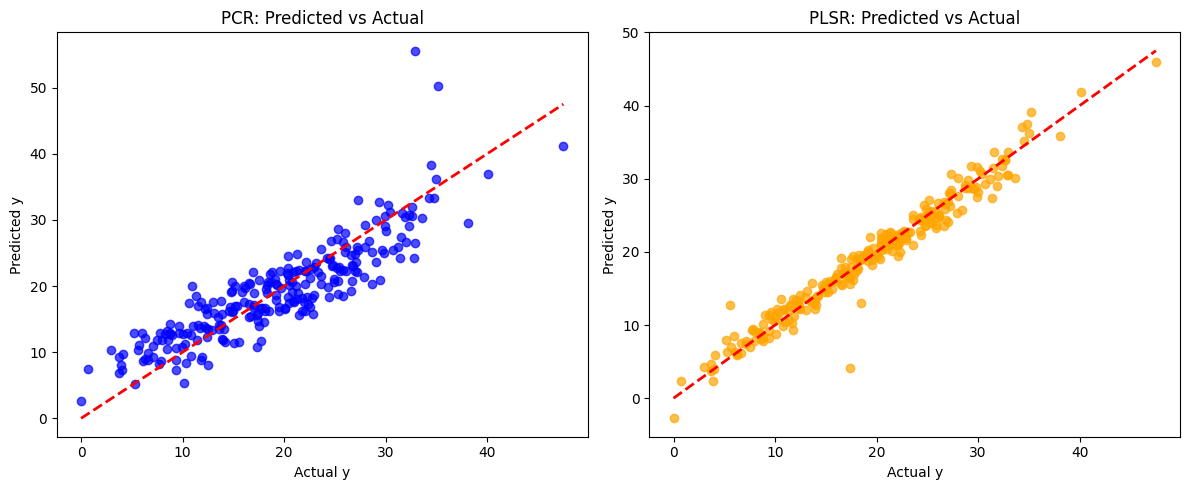

,Method,R2,RMSE,MAE
0,PCR,0.770959,3.997174,3.127552
1,PLS,0.959906,1.672393,1.145138


In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# --- Prepare PCR ---
X = data.drop(['class'], axis=1)
y = data['class']
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
reg = LinearRegression()
reg.fit(X_pca, y)
y_pred_pcr = reg.predict(X_pca)

# --- Prepare PLS ---
pls = PLSRegression(n_components=3)
pls.fit(X, y)
y_pred_pls = pls.predict(X).ravel()  # Flatten for compatibility

# --- Plot: Predicted vs Actual (PCR vs. PLS) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# PCR
axes[0].scatter(y, y_pred_pcr, color='blue', alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual y')
axes[0].set_ylabel('Predicted y')
axes[0].set_title('PCR: Predicted vs Actual')
# PLS
axes[1].scatter(y, y_pred_pls, color='orange', alpha=0.7)
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Actual y')
axes[1].set_ylabel('Predicted y')
axes[1].set_title('PLSR: Predicted vs Actual')
plt.tight_layout()
plt.show()

# --- Error metrics ---
metrics = {
    'Method': ['PCR', 'PLS'],
    'R2': [
        r2_score(y, y_pred_pcr),
        r2_score(y, y_pred_pls)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y, y_pred_pcr)),
        np.sqrt(mean_squared_error(y, y_pred_pls))
    ],
    'MAE': [
        mean_absolute_error(y, y_pred_pcr),
        mean_absolute_error(y, y_pred_pls)
    ]
}
metrics_df = pd.DataFrame(metrics)
display(metrics_df)


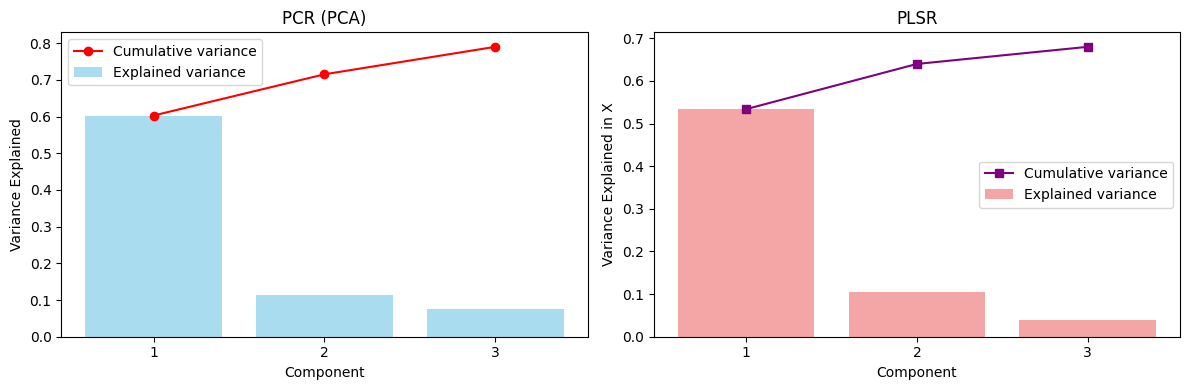

In [ ]:
# @title

import numpy as np
import matplotlib.pyplot as plt

# --- For PCR (PCA) ---
explained_pca = pca.explained_variance_ratio_
cum_pca = np.cumsum(explained_pca)

# --- For PLS ---
X_scores = pls.x_scores_
explained_pls = np.var(X_scores, axis=0) / np.sum(np.var(X_scaled, axis=0))
cum_pls = np.cumsum(explained_pls)

x = np.arange(1, len(explained_pca)+1)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# PCR (PCA)
axes[0].bar(x, explained_pca, alpha=0.7, color='skyblue', label='Explained variance')
axes[0].plot(x, cum_pca, marker='o', color='red', label='Cumulative variance')
axes[0].set_title('PCR (PCA)')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_xticks(x)
axes[0].legend()

# PLS
axes[1].bar(x, explained_pls, alpha=0.7, color='lightcoral', label='Explained variance')
axes[1].plot(x, cum_pls, marker='s', color='purple', label='Cumulative variance')
axes[1].set_title('PLSR')
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Variance Explained in X')
axes[1].set_xticks(x)
axes[1].legend()

plt.tight_layout()
plt.show()

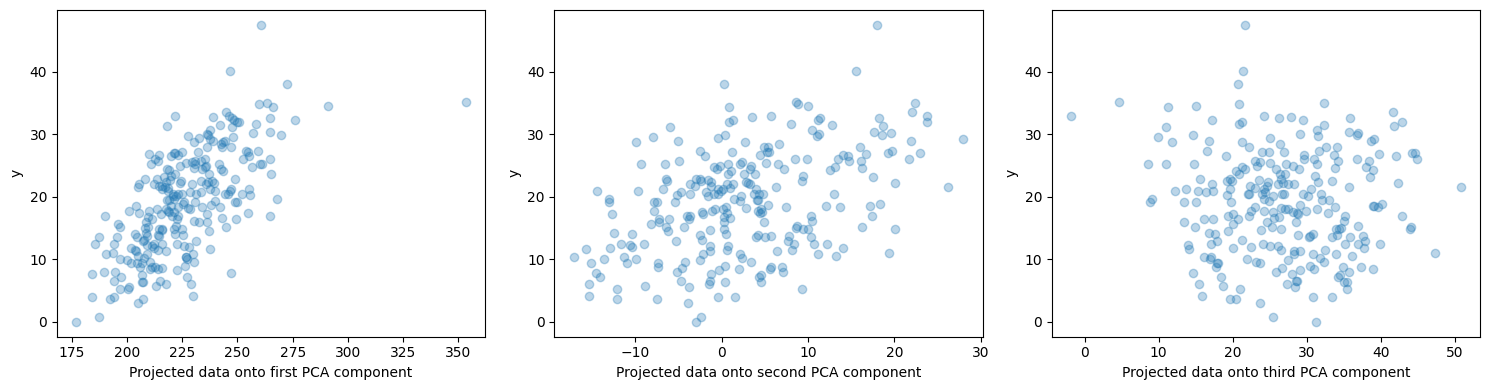

In [ ]:
# @title
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Second plot: Projected on 1st component vs y
axes[0].scatter(X.dot(pca.components_[0]), y, alpha=0.3)
axes[0].set(
    xlabel="Projected data onto first PCA component",
    ylabel="y",
  )

#  Projected on 2nd component vs y
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=0.3)
axes[1].set(
    xlabel="Projected data onto second PCA component",
    ylabel="y",
)

#  Projected on 3rd component vs y
axes[2].scatter(X.dot(pca.components_[2]), y, alpha=0.3)
axes[2].set(
    xlabel="Projected data onto third PCA component",
    ylabel="y",
)
plt.tight_layout()
plt.show()


### Conclusion


- **PCR** uses principal components from PCA to remove multicollinearity, focusing on variance in predictors (`X`).
- **PLSR** goes further by selecting components that are most predictive of the target variable (`Y`).
- Choose **PCR** when your goal is to explore or understand the structure in `X`, not necessarily to predict `Y`.
- Choose **PLSR** when your main goal is accurate prediction of `Y`, especially when `X` and `Y` are strongly related.
